In [1]:
import numpy as np
from astropy.cosmology import Planck18 as cosmo
import astropy.constants as cst
import astropy.units as u
import pylab as plt
import pyccl as ccl
from scipy import integrate, interpolate
from scipy.signal import find_peaks
from numpy.fft import fft2, ifft2, fftfreq

# 1. Basic Information

We know:
$$
\nabla^2 \psi = 2\frac{\Sigma({\bm \theta})}{\Sigma_\mathrm{crit}} = 2\kappa({\bm \theta})
$$
and in the given example of Fig 4. in 1707.00003, it is given that
$$
\begin{aligned}
\kappa_\star &= 17.1\kappa_c = 3.25\times10^{-4} \\
d &= 4.97\ \mathrm{arcmin}^{-1} \\
\theta_\star &= 1\ \mu\mathrm{as}
\end{aligned}
$$

In [2]:
kappa_star = 3.25*1e-4
kappa_c = kappa_star/17.1
d = 4.97*u.arcmin**(-1)
theta_star = 1e-6*u.arcsec #1e-6*u.arcsec
z_l = 0.54
z_s = 1.49

In [3]:
D_l = ccl.angular_diameter_distance(ccl.CosmologyVanillaLCDM(),1./(1.+z_l))*u.Mpc
D_l

<Quantity 1368.98534133 Mpc>

In [4]:
D_s = ccl.angular_diameter_distance(ccl.CosmologyVanillaLCDM(),1./(1.+z_s))*u.Mpc
D_s

<Quantity 1823.00403554 Mpc>

In [5]:
D_ls = ccl.angular_diameter_distance(ccl.CosmologyVanillaLCDM(),1./(1.+z_l),1./(1.+z_s))*u.Mpc
D_ls

<Quantity 976.32233849 Mpc>

We shall start with Eqn. 16, Einstein Radius:
$$
\theta_\star = \sqrt{\frac{4GM_l}{c^2}\frac{D_{ls}}{D_lD_s}} = 1\mu\mathrm{as}\left(\frac{M_*}{0.3M_\odot}\right)^{1/2}\left(2.55\mathrm{Gpc}\dfrac{D_{ls}}{D_lD_s}\right)^{1/2}
$$

In [6]:
def theta_E(M,Dl,Ds,Dls=None):
    if Dls == None:
        Dls = Ds-Dl
    return np.sqrt((4*cst.G*M/(cst.c**2))/(Dl*Ds/Dls)).to(u.arcsec,equivalencies=u.dimensionless_angles())

def M_star_from_thetaE(theta_E,Dl,Ds,Dls=None):
    if Dls == None:
        Dls = Ds-Dl
    return (theta_E**2*(Dl*Ds/Dls)*(cst.c**2/(4*cst.G))).to(u.Msun,equivalencies=u.dimensionless_angles())

def theta_E_2(M,Dl,Ds,Dls=None):
    if Dls == None:
        Dls = Ds-Dl
    Mterm = np.sqrt(M/(0.3*u.M_sun))
    Dterm = np.sqrt(2.55*u.Gpc*Dls/(Dl*Ds))
    return 1e-6*u.arcsec*(Mterm*Dterm).si

def M_star_from_theta_E2(theta_E,Dl,Ds,Dls=None):
    if Dls == None:
        Dls = Ds-Dl
    Tterm = (theta_E/(1e-6*u.arcsec))**2
    Dterm = 2.55*u.Gpc*Dls/(Dl*Ds)
    return (Tterm/Dterm*0.3*u.Msun).to(u.Msun)

M_star = M_star_from_thetaE(theta_star,D_l,D_s,D_ls)
M_star

<Quantity 0.31387972 solMass>

typical seperation between neighbouring masses is:
$$
r_s \simeq \theta_\star\kappa_\star^{-1/2}
$$

In [7]:
r_s = theta_star/np.sqrt(kappa_star)
r_s

<Quantity 5.54700196e-05 arcsec>

The lensing Jacobian matrix can be written as:
$$
{\bm A} = \begin{pmatrix}
1 - \kappa - \gamma_1 & -\gamma_2 \\
-\gamma_2 & 1 - \kappa + \gamma_1
\end{pmatrix}
$$
where $\gamma = \gamma_1 + i\gamma_2$, and magnification is $\mu = \left((1-\kappa)^2 - |\gamma|^2\right)^{-1}$. 

Lensing potential for a point mass:
$$
\psi(\vec{\vartheta};\vec{\theta}) = \frac{\theta_E^2}{2}\ln\left|\frac{D_l}{4D_{ls}}(\vec{\vartheta} - \vec{\theta})^2\right|
$$
for a point mass at $\vec{\theta}$. For convenience, let's define a $\vec{\Theta} = \vec{\vartheta} - \vec{\theta}$:
$$
\psi(\vec{\Theta}) = \frac{\theta_E^2}{2}\ln\left(\frac{\Theta_1^2 + \Theta_2^2}{4D_lD_{ls}}\right)
$$

and convergence $\kappa$, shear $\gamma = \gamma_1 + i\gamma_2$ is:
$$
\begin{aligned}
\kappa &= \frac{1}{2}\left(\partial_{xx} + \partial_{yy}\right)\psi \\
&\propto \delta(\vec{\Theta}) \\
\gamma_1 &= \frac{1}{2}\left(\partial_{xx} - \partial_{yy}\right)\psi \\
&= \frac{\theta_E^2(\Theta_2^2 - \Theta_1^2)}{(\Theta_1^2 + \Theta_2^2)^2} \\
\gamma_2 &= \partial_x\partial_y \psi \\
&= - \frac{2\theta_E^2\Theta_1\Theta_2}{(\Theta_1^2 + \Theta_2^2)^2}
\end{aligned}
$$

The inverse magnification is the determinant of lensing matrix $A(\Theta)$:
$$
\begin{aligned}
\mu^{-1} &= (1-\kappa)^2 - \gamma_1^2 - \gamma_2^2 \\
&= 1 - \frac{\theta_E^4}{(\Theta_1^2 + \Theta_2^2)^2}
\end{aligned}
$$
Therefore, basically, for a point-mass, the Einstein radius is at where the critical curve is. However, in the system we are considering, we at least needs to consider its macroscopic effect:
$$
\mu^{-1} = (1-\kappa_\star)^2 - (\gamma_{1,*} + \gamma_{1,\star})^2 - (\gamma_{2,*} + \gamma_{2,\star})^2
$$

In [8]:
as2rad = ((1*u.arcsec).to(u.rad)).value
as2rad

4.84813681109536e-06

In [9]:
def lensing_psi_(theta_E_in,Theta_1,Theta_2,Dl=D_l,Dls=D_ls):
    Theta1 = as2rad*Theta_1
    Theta2 = as2rad*Theta_2
    return 0.5*theta_E_in**2*np.log((Theta1**2+Theta2**2)*Dl/(4*Dls))

def psi_local_kappa_(Theta1_origin,Theta2_origin,kappa):
    return kappa/2.0*(Theta1_origin**2 + Theta2_origin**2)

def gamma_1_(Theta_1,Theta_2,theta_E_in):
    return theta_E_in**2*(Theta_2**2-Theta_1**2)/(Theta_1**2 + Theta_2**2)**2

def gamma_2_(Theta_1,Theta_2,theta_E_in):
    return 2*theta_E_in**2*(Theta_1*Theta_2)/(Theta_1**2 + Theta_2**2)**2

In [10]:
def invmu(kp_st,g1_st,g2_st,g1_ml,g2_ml):
    return (1-kp_st)**2 - (g1_ml+g1_st)**2 - (g1_ml+g2_ml)**2

In [11]:
res = 1*10**(-6)
lenx = 3000
leny = 3000
x = np.arange(lenx)*res#*u.arcsec
y = np.arange(leny)*res#*u.arcsec
halfx = x[int(lenx/2)]
halfy = y[int(lenx/2)]
x_grid,y_grid = np.meshgrid(x,y)
halfx

0.0015

# 2. Macroscopic Critical Curve
Let's throw in the information of MACS J1149.5+2223

In [12]:
M_clus = 5.5e14*u.Msun
theta_E_clus_as = theta_E(M_clus,D_l,D_s)
theta_E_clus = (theta_E_clus_as.to(u.arcsec)).value
theta_E_clus

28.545652114337123

In [13]:
M_clus = M_star_from_thetaE(theta_E_clus*u.arcsec,D_l,D_s)
M_clus

<Quantity 5.5e+14 solMass>

In [14]:
x_clus = - theta_E_clus - 2.09*halfx #3.64 for 0.002
# 2.09 or 3.64 is a Fine Tuning to make the critical curve located at the centre of the plot
y_clus = halfy
T1_clus = x_grid - x_clus
T2_clus = y_grid - y_clus

gamma_1_clus = gamma_1_(T1_clus,T2_clus,theta_E_clus)
gamma_2_clus = gamma_2_(T1_clus,T2_clus,theta_E_clus)
invmu_clus_only = invmu(kappa_star,gamma_1_clus,gamma_2_clus,0.0,0.0)

In [15]:
maximum_angle = (np.arctan(y_clus/x_clus)*u.rad).to(u.deg,equivalencies=u.dimensionless_angles())
maximum_angle

<Quantity -0.00301041 deg>

Therefore we can omit y component of the macroscopic -- the error from this step is smaller than our other assumptions

In [16]:
#Lensing_psi_clus = lensing_psi_(theta_E_clus,T1_clus,T2_clus)
#Lensing_psi_kappa = psi_local_kappa_(T1_clus,T2_clus,kappa_star)
#tau_clus = 0.5*(T1_clus**2 + T2_clus**2) - Lensing_psi_clus - Lensing_psi_kappa
Lensing_psi_clus = lensing_psi_(theta_E_clus,T1_clus,0.0)
Lensing_psi_kappa = psi_local_kappa_(T1_clus,0.0,kappa_star)
Lensing_psi_macro = Lensing_psi_clus + Lensing_psi_kappa
tau_clus = 0.5*(T1_clus**2) - Lensing_psi_macro

In [17]:
# Macroscopic Magnification
mu_clus_only = np.abs(1./(invmu_clus_only))

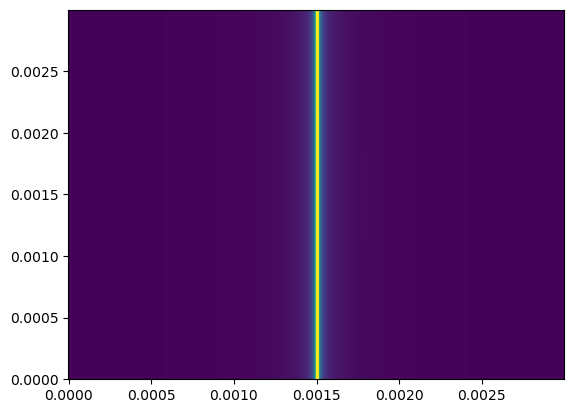

In [18]:
plt.figure(dpi=100)
plt.pcolormesh(x_grid,y_grid,mu_clus_only,vmin=0.0,vmax=1000000.0)
plt.show()

# 3. Caustics
整明白Caustics的物理意义之后我发现“焦散线”这个中文翻译是真\*仙舟粗口\*好啊\
Now let's populate the field with a bunch of microlenses with $r_s$ (Eq. (4)) 

In [19]:
# The algorithm to determine how many microlenses should appear in the field
# Very random, feel free to add more rules to this sampling
lambda_density = 1 / (4 * r_s**2)
A = x[-1]*u.arcsec*y[-1]*u.arcsec
N_mcls = lambda_density * A
N_mcls

<Quantity 730.76258125>

In [20]:
gamma_1_mcls = 0.0
gamma_2_mcls = 0.0
gamma_1_mclsp = 0.0
gamma_2_mclsp = 0.0
n_mcls = int(np.around(N_mcls))
theta_E_mcls = 1e-6
np.random.seed(42)
x_ = np.random.uniform(0,lenx,n_mcls)
y_ = np.random.uniform(0,leny,n_mcls)
x_mclsi = x_*res
y_mclsi = y_*res
Lensing_psi_mcls = 0.0
Lensing_psi_mclsp = 0.0
for i_ in range(n_mcls):
    T1_mclsi = x_grid - x_mclsi[i_]
    T1_mclsi_periodic = 1.0*T1_mclsi
    T1_mclsi_periodic[T1_mclsi > halfx] -=  2*halfx
    T1_mclsi_periodic[T1_mclsi < -halfx] +=  2*halfx
    T2_mclsi = y_grid - y_mclsi[i_]
    T2_mclsi_periodic = 1.0*T2_mclsi
    T2_mclsi_periodic[T2_mclsi > halfy] -=  2*halfy
    T2_mclsi_periodic[T2_mclsi < -halfy] +=  2*halfy
    gamma_1_mclsi = gamma_1_(T1_mclsi,T2_mclsi,theta_E_mcls)
    gamma_2_mclsi = gamma_2_(T1_mclsi,T2_mclsi,theta_E_mcls)
    psi_mclsi = lensing_psi_(theta_E_mcls,T1_mclsi,T2_mclsi)
    gamma_1_mclsip = gamma_1_(T1_mclsi_periodic,T2_mclsi_periodic,theta_E_mcls)
    gamma_2_mclsip = gamma_2_(T1_mclsi_periodic,T2_mclsi_periodic,theta_E_mcls)
    psi_mclsip = lensing_psi_(theta_E_mcls,T1_mclsi_periodic,T2_mclsi_periodic)
    gamma_1_mcls = gamma_1_mcls + gamma_1_mclsi
    gamma_2_mcls = gamma_2_mcls + gamma_2_mclsi
    gamma_1_mclsp = gamma_1_mclsp + gamma_1_mclsip
    gamma_2_mclsp = gamma_2_mclsp + gamma_2_mclsip
    Lensing_psi_mcls = Lensing_psi_mcls+psi_mclsi
    Lensing_psi_mclsp = Lensing_psi_mclsp+psi_mclsip

invmu_clus_mcls = invmu(kappa_star,gamma_1_clus,gamma_2_clus,gamma_1_mcls,gamma_2_mcls)
invmu_clus_mclsp = invmu(kappa_star,gamma_1_clus,gamma_2_clus,gamma_1_mclsp,gamma_2_mclsp)

In [21]:
mu_clus_mcls = np.abs(1./(invmu_clus_mcls))
mu_clus_mclsp = np.abs(1./(invmu_clus_mclsp))

In [22]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def plot_critical_curve_ridge(data, colour='red',size=0.8,label=None,sigma=1.0, threshold=1.0):
    Helems = hessian_matrix(data, sigma=sigma)
    lambda1, lambda2 = hessian_matrix_eigvals(Helems)
    ridge_mask = (lambda1 < 0) & (np.abs(lambda1) > threshold)
    y, x = np.where(ridge_mask)
    plt.scatter(x*res, y*res, color=colour, s=size, alpha=0.5, label=label)

/tmp/ipykernel_1394/2778602814.py:4: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  Helems = hessian_matrix(data, sigma=sigma)


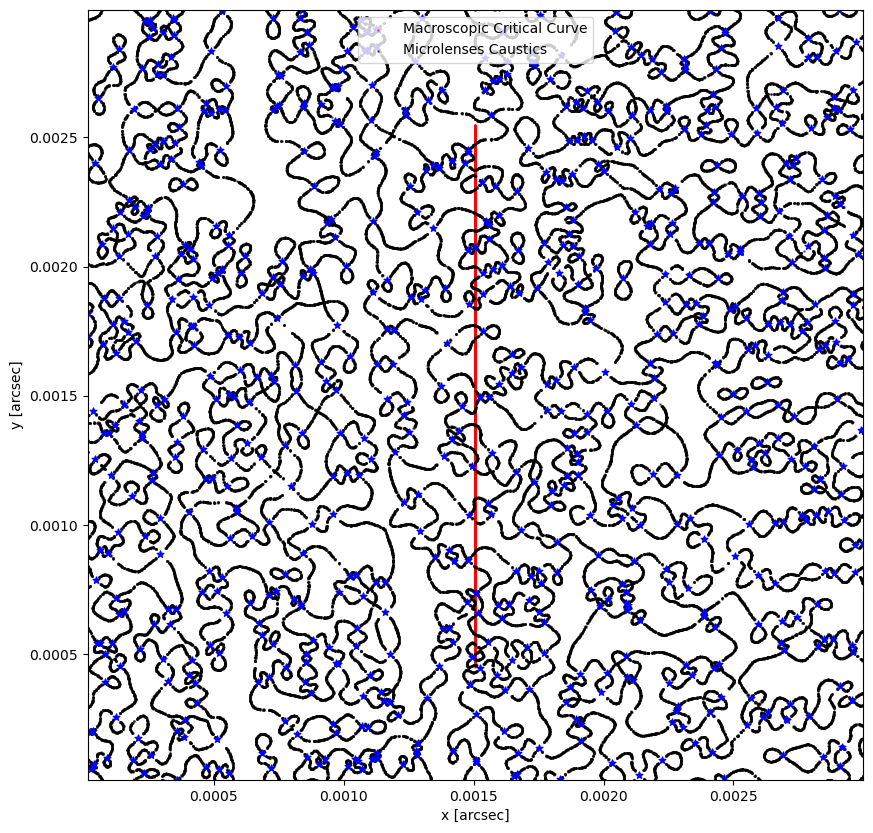

In [23]:
plt.figure(figsize=(10,10))
plot_critical_curve_ridge((mu_clus_only), colour='red', threshold=0.1, label='Macroscopic Critical Curve')
plot_critical_curve_ridge((mu_clus_mclsp), colour='black',sigma=1.0, threshold=10.0, label='Microlenses Caustics')
plt.scatter(x_mclsi,y_mclsi,s=25,marker='*',color='blue')
plt.legend()
plt.xlim(np.min(x_mclsi),np.max(x_mclsi))
plt.ylim(np.min(y_mclsi),np.max(y_mclsi))
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.show()
#plt.savefig('May26_Caustic.jpeg',dpi=100)

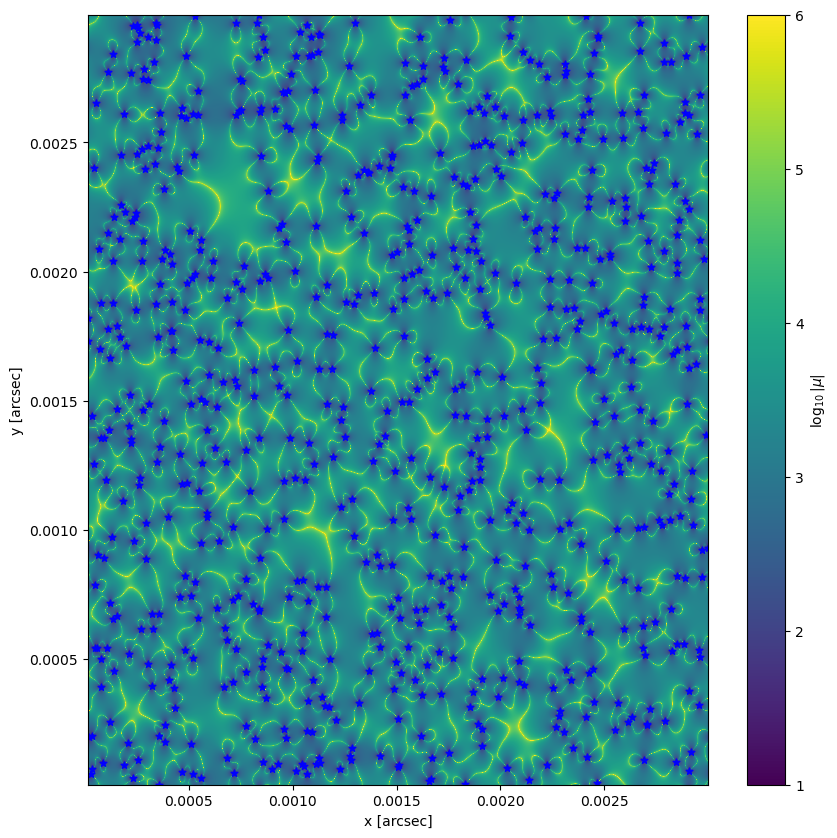

In [27]:
plt.figure(figsize=(10,10))
#plot_critical_curve_ridge((mu_clus_only), colour='red', threshold=0.1, label='Macroscopic Critical Curve')
plt.pcolormesh(x_grid,y_grid,np.log10(mu_clus_mclsp),vmin=1,vmax=6)
plt.colorbar(label='$\\log_{10}|\\mu|$')
plt.scatter(x_mclsi,y_mclsi,s=25,marker='*',color='blue')
#plt.legend()
plt.xlim(np.min(x_mclsi),np.max(x_mclsi))
plt.ylim(np.min(y_mclsi),np.max(y_mclsi))
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.show()
#plt.savefig('May26_Magnification.jpeg',dpi=100)